In [1]:
from collections import namedtuple

import numpy as np
import pandas as pd
from rdt.transformers import NumericalTransformer, OneHotEncodingTransformer
import matplotlib.pyplot as plt

In [2]:
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo', [
        'column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'
    ]
)

In [32]:
"""DataTransformer module."""

from collections import namedtuple

import numpy as np
import pandas as pd
from rdt.transformers import BayesGMMTransformer, OneHotEncodingTransformer

SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo', [
        'column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'
    ]
)


class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalized to a scalar [0, 1] and a vector.
    Discrete columns are encoded using a scikit-learn OneHotEncoder.
    """

    def __init__(self, max_clusters=5, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = BayesGMMTransformer(max_clusters=self._max_clusters)
        gm.fit(data, [column_name])
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name, column_type='continuous', transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components)

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncodingTransformer()
        ohe.fit(data, [column_name])
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name, column_type='discrete', transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories)

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``BayesGMMTransformer`` for continuous columns and a
        ``OneHotEncodingTransformer`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        data[column_name] = data[column_name].to_numpy().flatten()
        gm = column_transform_info.transform
        transformed = gm.transform(data, [column_name])

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        column_data_list = []
        for column_transform_info in self._column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_types()))
        data.iloc[:, 1] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data, [column_transform_info.column_name])

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_types()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st:st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st)
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data)

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = (pd.DataFrame(recovered_data, columns=column_names)
                          .astype(self._column_raw_dtypes))
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot)
        }


In [4]:
CENSUS = 'http://ctgan-data.s3.amazonaws.com/census.csv.gz'
df = pd.read_csv(CENSUS, compression='gzip')

In [5]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [6]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

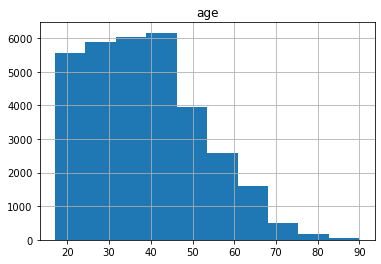

In [7]:
df.hist(column='age', bins=10)

array([[<AxesSubplot:title={'center':'fnlwgt'}>]], dtype=object)

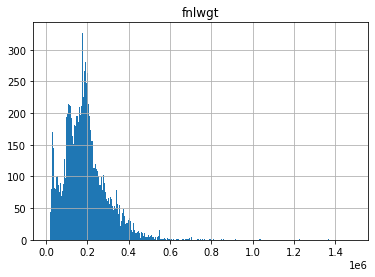

In [8]:
df.hist(column='fnlwgt', bins=1000)

array([[<AxesSubplot:title={'center':'capital-gain'}>]], dtype=object)

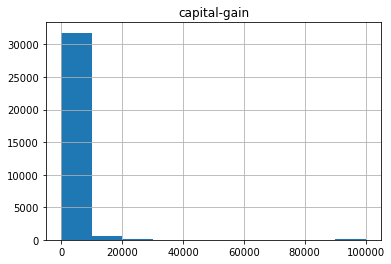

In [9]:
df.hist(column='capital-gain', bins=10)

array([[<AxesSubplot:title={'center':'capital-loss'}>]], dtype=object)

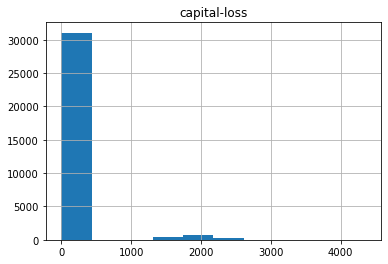

In [10]:
df.hist(column='capital-loss', bins=10)

array([[<AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

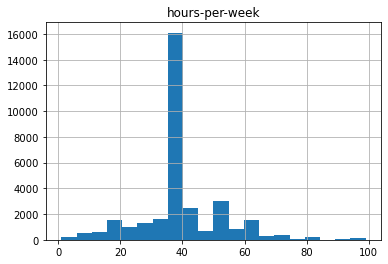

In [11]:
df.hist(column='hours-per-week', bins=20)

array([[<AxesSubplot:title={'center':'education-num'}>]], dtype=object)

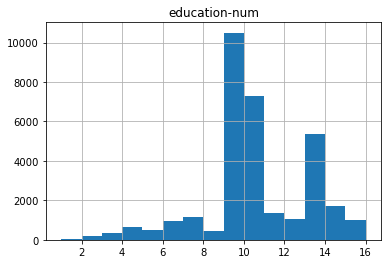

In [12]:
df.hist(column='education-num', bins=15)

In [13]:
from ctgan import CTGANSynthesizer
from ctgan import load_demo

data = load_demo()

# Names of the columns that are discrete
discrete_columns = [
    'workclass',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
]

ctgan = CTGANSynthesizer(epochs=10)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(1000)

/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge.

In [14]:
samples

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,33,Private,177782,11th,9,Married-civ-spouse,Adm-clerical,Husband,White,Female,114,-5,40,United-States,<=50K
1,31,Private,106615,Some-college,9,Married-civ-spouse,Protective-serv,Not-in-family,Asian-Pac-Islander,Male,95,-6,31,?,<=50K
2,22,State-gov,233290,Some-college,13,Never-married,Sales,Other-relative,White,Male,-14,-5,40,Italy,<=50K
3,59,Private,41076,9th,10,Never-married,Handlers-cleaners,Not-in-family,White,Male,36,-4,40,United-States,<=50K
4,31,Without-pay,164451,Some-college,11,Married-civ-spouse,Other-service,Other-relative,White,Male,79,-4,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,46,Private,330064,HS-grad,10,Never-married,Machine-op-inspct,Husband,White,Male,85,-4,51,United-States,<=50K
996,51,Private,144725,Bachelors,10,Married-civ-spouse,Tech-support,Own-child,White,Male,-68,2,40,United-States,<=50K
997,19,Self-emp-not-inc,83915,Bachelors,10,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,49,-7,23,United-States,>50K
998,18,Private,154010,Some-college,9,Divorced,Prof-specialty,Unmarried,White,Male,24,0,26,United-States,<=50K


array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

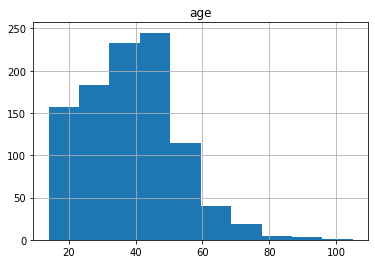

In [15]:
samples.hist(column='age', bins=10)

array([[<AxesSubplot:title={'center':'fnlwgt'}>]], dtype=object)

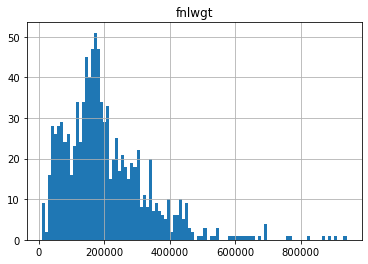

In [16]:
samples.hist(column='fnlwgt', bins=100)

array([[<AxesSubplot:title={'center':'capital-gain'}>]], dtype=object)

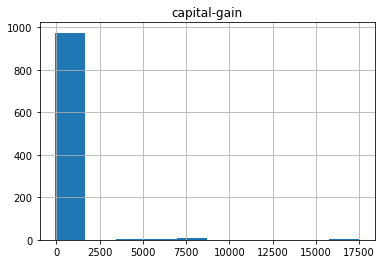

In [17]:
samples.hist(column='capital-gain', bins=10)

array([[<AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

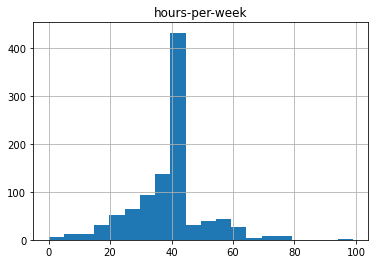

In [18]:
samples.hist(column='hours-per-week', bins=20)

array([[<AxesSubplot:title={'center':'education-num'}>]], dtype=object)

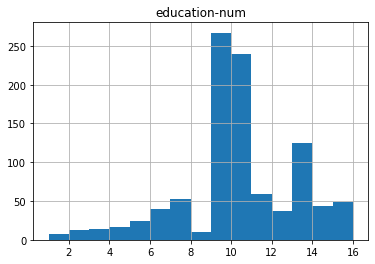

In [20]:
samples.hist(column='education-num', bins=15)

In [33]:
dt = DataTransformer()

dt.fit(df, discrete_columns=['workclass', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country',
       'income'])

tr_data = dt.transform(df)

print(tr_data.shape)

df.shape

np.set_printoptions(threshold=np.inf)
print(tr_data[7:8,])

print(dt.output_info_list)
dt.output_dimensions


/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/Caskroom/miniconda/base/envs/fact/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a

(32561, 146)
[[ 1.49741055e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.97223480e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

146

In [34]:
dt._column_transform_info_list

[ColumnTransformInfo(column_name='age', column_type='continuous', transform=<rdt.transformers.numerical.BayesGMMTransformer object at 0x7ff9c90e3b10>, output_info=[SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=5, activation_fn='softmax')], output_dimensions=6),
 ColumnTransformInfo(column_name='workclass', column_type='discrete', transform=<rdt.transformers.categorical.OneHotEncodingTransformer object at 0x7ff9c90e5110>, output_info=[SpanInfo(dim=9, activation_fn='softmax')], output_dimensions=9),
 ColumnTransformInfo(column_name='fnlwgt', column_type='continuous', transform=<rdt.transformers.numerical.BayesGMMTransformer object at 0x7ff9c90e5cd0>, output_info=[SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=5, activation_fn='softmax')], output_dimensions=6),
 ColumnTransformInfo(column_name='education', column_type='discrete', transform=<rdt.transformers.categorical.OneHotEncodingTransformer object at 0x7ff9f88d1790>, output_info=[SpanInfo(dim=16, activation_fn='softmax')], 